# Detecting Lung Disease Using CNNs

In [1]:
%matplotlib inline

import os
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import pandas as pd
from keras.applications import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

## Loading in the Data

In [2]:
data_path = './xray_data/'
train_path = data_path + 'train/'
test_path = data_path + 'test/'

In [3]:
df = pd.read_csv("/Users/audreywiseman/Desktop/ANN/xray_data/Data_Entry_2017.csv")
df["Finding Labels"]=df["Finding Labels"].apply(lambda x:x.split(","))

classes = ["No Finding", 
           "Atelectasis", 
           "Consolidation", 
           "Infiltration",
           "Pneumothorax",
           "Edema",
           "Emphysema",
           "Fibrosis",
           "Effusion",
           "Pneumonia",
           "Pleural_Thickening",
           "Cardiomegaly",
           "Mass",
           "Nodule",
           "Hernia"]

datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

# using 50000/86524 training images
train_it=datagen.flow_from_dataframe(dataframe=df[:15000], 
                                            directory=train_path, 
                                            x_col="Image Index", 
                                            y_col="Finding Labels", 
                                            batch_size=32, 
                                            seed=42, 
                                            shuffle=True, 
                                            class_mode="categorical",
                                            classes=classes,
                                            target_size=(1024,1024))
test_it=test_datagen.flow_from_dataframe(dataframe=df[86524:],
                                                directory=test_path,
                                                x_col="Image Index",
                                                y_col="Finding Labels",
                                                batch_size=1,
                                                seed=42,
                                                shuffle=False,
                                                class_mode="categorical",
                                                classes=classes,
                                                target_size=(1024,1024))

/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2459 invalid image filename(s) in x_col="Image Index". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 10960 validated image filenames belonging to 15 classes.
Found 5368 validated image filenames belonging to 15 classes.


/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 18237 invalid image filename(s) in x_col="Image Index". These filename(s) will be ignored.
  .format(n_invalid, x_col)


## Creating the Model
Next, I am going to create the model that will train on the Chest X-Rays. I am going to start with a pre-trained network and see if that helps training go more smoothly. I am using categorical crossentropy as my loss function to allow for multiple labels being present. I also use sigmoid activation to accommodate multiple labels. 

In [ ]:
# load model without classifier layers
model = DenseNet121(include_top=False, input_shape=(1024, 1024, 3), weights='imagenet', pooling='max')

# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='sigmoid')(flat1)
output = Dense(15, activation='sigmoid')(class1)

# define new model
model = Model(inputs=model.inputs, outputs=output)

for layer in model.layers[:-2]:
    layer.trainable=False
    
model.compile(loss=[tfa.losses.SigmoidFocalCrossEntropy(gamma=2.0)], metrics=["accuracy"], optimizer='adam')
history = model.fit(train_it, batch_size=128, epochs=10)

Epoch 1/10
  2/343 [..............................] - ETA: 6:54:49 - loss: 1.7262 - accuracy: 0.1719    

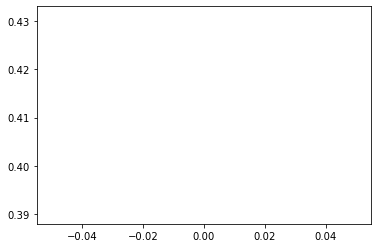

In [5]:
plt.plot(history.history['loss'])

In [13]:
model.evaluate(x_test, y_test)

16/16 [==============================] - 1101s 68s/step - loss: 0.1159 - accuracy: 1.0000


[0.11587262153625488, 1.0]